## Problem Formalization with pymoo

### Multi-Objective EV Control Problem
We model the **Electric Vehicle Control Problem** as a constrained bi-objective optimization:

\begin{aligned}
\text{Minimize:} \quad & \mathbf{J}(u) = \begin{bmatrix} T \\ E(u) \end{bmatrix} \\
\text{Subject to:} \quad & \text{Dynamics and constraints below}
\end{aligned}

---

### Objectives

1. **Minimize Arrival Time**  
    \begin{aligned}
   T = \inf \left\{ t \, \big| \, x(t) = D \right\}
   \end{aligned}
   - $D$: Total travel distance  
   - $x(t)$: Position at time $t$

2. **Minimize Energy Consumption**  
   \begin{aligned}
   E(u) = \int_0^T P\big(u(t), v(t)\big) \, dt
   \end{aligned}
   \begin{aligned}
   P(u,v) = \frac{u(t) \cdot v(t)}{\eta} + P_{\text{aux}}
   \end{aligned}
   - $\eta$: Motor efficiency (0 < $\eta$ ≤ 1)  
   - $P_{\text{aux}}$: Constant auxiliary power  
   - $u(t)$: Control input (acceleration/deceleration)  
   - $v(t)$: Velocity

---

### Vehicle Dynamics (Constraints)

\begin{aligned}
\begin{cases}
\dot{x}(t) = v(t) & \text{(Position dynamics)} \\
\dot{v}(t) = u(t) - \frac{1}{m}\big(F_{\text{drag}}(v(t)) + F_{\text{roll}}\big) & \text{(Velocity dynamics)} \\
F_{\text{drag}}(v) = \frac{1}{2} \rho C_d A v^2 & \text{(Drag force)} \\
F_{\text{roll}} = C_r m g & \text{(Rolling resistance)}
\end{cases}
\end{aligned}

**Boundary Conditions**:
\begin{aligned}
x(0) = 0, \quad v(0) = 0, \quad x(T) = D
\end{aligned}

**Control and State Constraints**:
\begin{aligned}
u_{\text{min}} \leq u(t) \leq u_{\text{max}}, \quad 0 \leq v(t) \leq v_{\text{max}}
\end{aligned}

---

### Pareto Optimality
The Pareto front $ \mathcal{X}_{\text{Pareto}} $ consists of non-dominated solutions:
\begin{aligned}
\mathcal{X}_{\text{Pareto}} = \left\{ \mathbf{J}_i = [T_i, E_i]^T \, \big| \, \nexists \, \mathbf{J}_j \text{ where } T_j \leq T_i \text{ and } E_j \leq E_i \right\}
\end{aligned}


In [89]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class EVControlProblem(Problem):
    def __init__(self):
        # Revised physical constants
        self.mass = 1000        # Reduced mass [kg]
        self.rho = 1.225        # air density [kg/m³]
        self.Cd = 0.24          # drag coefficient
        self.A = 2.4            # frontal area [m²]
        self.Cr = 0.008         # Reduced rolling coefficient
        self.eta = 0.85         # Improved motor efficiency
        self.P_aux = 300        # Reduced auxiliary power [W]
        self.v_max = 30         # speed limit [m/s]
        self.distance = 1000    # total distance [m]

        # Bounds for acceleration/deceleration [m/s²]
        xl = np.array([0.3, 0.3])  # Wider lower bounds
        xu = np.array([4.0, 4.0])   # Wider upper bounds

        # 2 objectives, 2 variables, 4 constraints
        super().__init__(n_var=2, n_obj=2, n_constr=4, xl=xl, xu=xu)

    def _calculate_drag(self, v):
        return 0.5 * self.rho * self.Cd * self.A * v**2

    def _calculate_rolling_resistance(self):
        return self.Cr * self.mass * 9.81

    def _simulate_motion(self, a1, a2):
        """Returns (total_time, velocity_profile, time_steps, t_accel, t_decel, v_max_reached)"""
        # Phase 1: Acceleration
        t_accel = min(self.v_max/a1, np.sqrt(2*self.distance/a1))
        v_max_reached = a1 * t_accel

        # Phase 2: Deceleration
        d_accel = 0.5 * a1 * t_accel**2
        remaining_d = max(0, self.distance - d_accel)
        t_decel = np.sqrt(2*remaining_d/a2) if a2 > 0 else 0
        total_time = t_accel + t_decel

        # Generate velocity profile
        t_steps = np.linspace(0, total_time, 100)
        v = np.piecewise(t_steps,
                        [t_steps <= t_accel, t_steps > t_accel],
                        [lambda t: a1*t,
                         lambda t: v_max_reached - a2*(t-t_accel)])
        return total_time, v, t_steps, t_accel, t_decel, v_max_reached

    def _calculate_energy(self, a, v, t):
        """Calculates energy consumption in kWh"""
        drag = self._calculate_drag(v)
        rolling = self._calculate_rolling_resistance()
        power = (a * v * (self.mass + drag + rolling)) / self.eta + self.P_aux
        return np.trapezoid(power, t) / (1000 * 3600)  # Use trapezoid

    def _evaluate(self, X, out, *args, **kwargs):
        T, E, G = [], [], []
        for a1, a2 in X:
            total_time, v_profile, t_steps, t_accel, t_decel, v_max_reached = self._simulate_motion(a1, a2)

            # Acceleration profile
            peak_idx = np.argmax(v_profile)
            a_profile = np.where(t_steps <= t_steps[peak_idx], a1, -a2)

            # Energy calculation
            energy = self._calculate_energy(a_profile, v_profile, t_steps)

            # Final position calculation
            x_final = 0.5*a1*t_accel**2 + (v_max_reached*t_decel - 0.5*a2*t_decel**2)

            # Normalized constraints (g <= 0)
            g1 = (max(v_profile) - self.v_max) / self.v_max  # Speed limit
            g2_pos = (x_final - self.distance) / self.distance  # Distance upper
            g2_neg = (self.distance - x_final) / self.distance  # Distance lower
            g3 = (energy - 1.5) / 1.5  # Energy limit (1.5 kWh)

            T.append(total_time)
            E.append(energy)
            G.append([g1, g2_pos, g2_neg, g3])

        out["F"] = np.column_stack([T, E])
        out["G"] = np.array(G)


## 2. Optimizing with NSGA-II  
We use the **NSGA-II** (Non-dominated Sorting Genetic Algorithm II) to generate the **Pareto front**.  

### Key Metrics  
- **`n_gen`**: Current generation (iteration).  
- **`n_eval`**: Total number of function evaluations performed so far.  
  - Example: `n_eval = 1000` means the objective functions (time and energy) have been evaluated **1000 times cumulatively**.  
- **`n_nds`**: Number of **non-dominated solutions** (Pareto-optimal solutions) in the current population.  

### Epsilon (ε) Progress Metric (`eps`)  
Measures improvement between generations:  
- **Small values (e.g., `0.001`)** → Minimal improvement (algorithm is **converging**).  
- **Large values (e.g., `0.02`)** → Significant changes in the Pareto front.  
- **`-`** (dash) → No value computed (typically in the first generation).  

### Indicator  
Reference point used to compute `eps`:  

| Value    | Description                                                                 |
|----------|-----------------------------------------------------------------------------|
| `ideal`  | Improvement relative to the **ideal point** (best possible objective values). |
| `nadir`  | Improvement relative to the **nadir point** (worst values on Pareto front).  |
| `f`      | Generic improvement metric (often based on distances in objective space).    |

In [90]:
# Optimization setup
problem = EVControlProblem()
algorithm = NSGA2(pop_size=100)  # Larger population for more solutions
termination = ('n_gen', 100)

result = minimize(
    problem,
    algorithm,
    termination,
                   save_history=True,

    seed=42,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.136868E-16 |  0.5331234353 |             - |             -
     2 |      200 |      2 |  0.000000E+00 |  0.1445747627 |             - |             -
     3 |      300 |     11 |  0.000000E+00 |  0.0256747121 |  0.4427062663 |         ideal
     4 |      400 |     26 |  0.000000E+00 |  9.205917E-10 |  0.0789023546 |         ideal
     5 |      500 |     49 |  0.000000E+00 |  5.798029E-17 |  0.0130703807 |             f
     6 |      600 |     82 |  0.000000E+00 |  2.046363E-17 |  0.0015917380 |             f
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0091613260 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014840020 |             f
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0420900116 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013050420 |             f

In [91]:
# Show first 5 pareto-solutions
print(f"All solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy):")
print(result.F[:5])

All solutions shape: (100, 2)
First 5 solutions (Time, Energy):
[[81.64965809  0.122915  ]
 [66.66723869  0.18750152]
 [81.64965809  0.122915  ]
 [66.66723869  0.18750152]
 [69.24361236  0.17284801]]


## 3. Extract and Visualize Pareto Solutions
Get Non-Dominated Solutions


In [92]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract all solutions
F = result.F  # Objective values (T, E)

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices]

print(f"Found {len(pareto_front)} Pareto-optimal solutions.")


Found 1 Pareto-optimal solutions.


### Visualize the Pareto Front


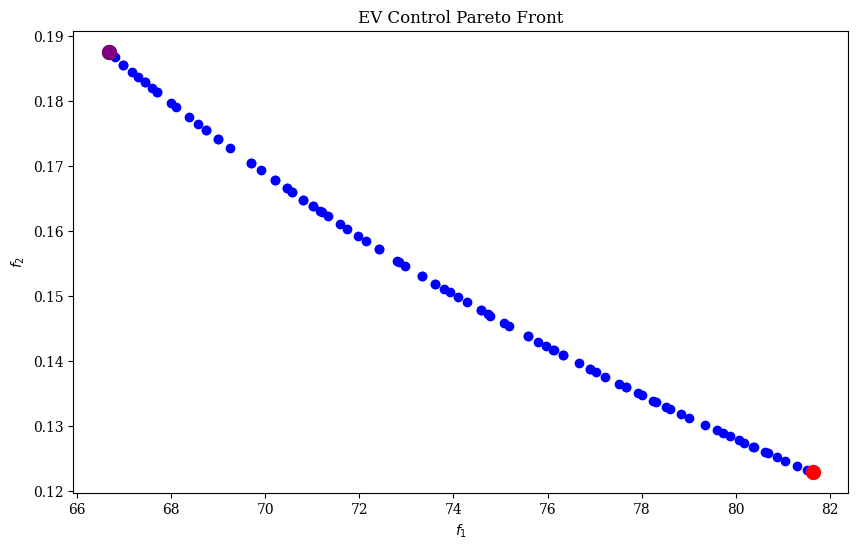

In [100]:
scatter = Scatter(title="EV Control Pareto Front",
                     axis_labels=["Time [s]", "Energy [kWh]"],
                     figsize=(10, 6))
scatter.add(result.F, color="blue", label="Solutions")
scatter.add(result.F[result.F[:,1].argmin()], color="red", s=100,
            label="Min Energy (%.2f kWh)" % result.F[:,1].min())
scatter.add(result.F[result.F[:,0].argmin()], color="green", s=100,
            label="Min Time (%.1f s)" % result.F[:,0].min())
scatter.add(result.F[np.argmin(result.F[:,0] + result.F[:,1])], color="purple", s=100,
            label="Best Compromise")
scatter.show()